<a href="https://colab.research.google.com/github/pkulium/notes/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IST-DASLab/sparsegpt/blob/master/demo.ipynb)

Install dependencies

In [29]:
!pip install -q datasets
!pip install -q transformers

Clone repository

In [30]:
!git clone https://github.com/IST-DASLab/sparsegpt

fatal: destination path 'sparsegpt' already exists and is not an empty directory.


### Pruning example
---

Below we will show an example of SparseGPT applied to OPT model.

In [31]:
%cd sparsegpt

/content/sparsegpt


Crerate directory to store prune model(s)

In [32]:
!mkdir -p sparse_opt

We will use `opt.py` script to prune the model.
Select one of the following OPT versions to fit into colab (with `bitsandbytes` one should be able to use larger 6.7b and 13b models):
* facebook/opt-125m
* facebook/opt-350m
* facebook/opt-1.3b

To prune the model select dataset for calibration (`c4`, `ptb` or `wikitext`). The SparseGPT paper uses `c4` by default.

One can prune model to uniform sparsity with SparseGPT either with unstructured pruning or semistructured `N:M` pattern.

To apply unstructured pruning specify `--sparsity` - floating point number in `[0, 1]`.

For semitstructured specify `--prunen` and `--prunem` arguments - integer numbers.

To apply magnitude pruning instead of SparseGPT select `--gmp` option.

To apply quantization on top of sparsity specify `--wbits`.

In the example below we prune `acebook/opt-125m` to 0.5 unstructured sparsity via SparseGPT. Try different options.


In [33]:
!python opt.py facebook/opt-125m c4 --sparsity 0.5 --save sparse_opt/opt-125m

2023-08-25 20:25:15.324885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.
Starting ...
Ready.
0 self_attn.k_proj
Pruning ...
time 0.54
error 13941.587890625
0 self_attn.v_proj
Pruning ...
time 0.16
error 547.517578125
0 self_attn.q_proj
Pruning ...
time 0.17
error 14149.1669921875
0 self_attn.out_proj
Pruning ...
time 0.16
error 6.390275001525879
0 fc1
Pruning ...
time 0.17
error 2260.54931640625
0 fc2
Pruning ...
time 0.71
error 36.479331970214844
1 self_attn.k_proj
Pruning ...
time 0.60
error 9682.548828125
1 self_attn.v_proj
Pruning ...
time 0.28
error 641.5951538085938
1 self_attn.q_proj
Pruning ...
time 0.28
error 4022.392578125
1 self_attn.out_proj
Pruning ...
time 0.24
error 4.027432441711426
1 fc1
Pruning ...
time 0.18
error 6266.3798828125
1 fc2
Pruning ...
time 0.69
error 14.219343185424805
2 se

Code above prints perplexity on `wikitext2`, `ptb` and `c4` benchmarks in the end.

### Compare generations
---

Let us compare generations produced by the dense and sparse model

In [34]:
from transformers import AutoTokenizer, OPTForCausalLM

In [35]:
device = 'cuda'

In [36]:
# load dense model
model_dn = OPTForCausalLM.from_pretrained('facebook/opt-125m', torch_dtype='auto').to(device)
# load sparse model
model_sp = OPTForCausalLM.from_pretrained('sparse_opt/opt-125m', torch_dtype='auto').to(device)
# init tokenizer
tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m')

In [37]:
input_text = "It takes a great deal of bravery"

In [38]:
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

Completion by dense model:

In [39]:
output_ids = model_dn.generate(input_ids)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [40]:
print(tokenizer.decode(output_ids[0].cpu(), skip_special_tokens=True))

It takes a great deal of bravery to get a job that pays you $15 an hour.


In [41]:
output_ids = model_sp.generate(input_ids)

In [42]:
print(tokenizer.decode(output_ids[0].cpu(), skip_special_tokens=True))

It takes a great deal of bravery to get a man to do something.

I'm


In [43]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip install peft

In [44]:
import random

import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, LlamaTokenizer


def set_seed(seed):
    np.random.seed(seed)
    torch.random.manual_seed(seed)

def get_tokenizer(model):
    if "llama" in model.lower():
        tokenizer = LlamaTokenizer.from_pretrained(model, use_fast=False)
        # fix for transformer 4.28.0.dev0 compatibility
        if tokenizer.bos_token_id != 1 or tokenizer.eos_token_id != 2:
            try:
                tokenizer.bos_token_id = 1
                tokenizer.eos_token_id = 2
            except AttributeError:
                pass
    else:
        tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m')
        # tokenizer = AutoTokenizer.from_pretrained(model, use_fast=False)
    return tokenizer

def get_wikitext2(nsamples, seed, seqlen, model, tokenizer):

    traindata = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')
    testdata = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')

    trainenc = tokenizer(" ".join(traindata['text']), return_tensors='pt')
    testenc = tokenizer("\n\n".join(testdata['text']), return_tensors='pt')

    random.seed(seed)
    trainloader = []
    for _ in range(nsamples):
        i = random.randint(0, trainenc.input_ids.shape[1] - seqlen - 1)
        j = i + seqlen
        inp = trainenc.input_ids[:, i:j]
        tar = inp.clone()
        tar[:, :-1] = -100
        trainloader.append((inp, tar))
    return trainloader, testenc

def get_ptb(nsamples, seed, seqlen, model, tokenizer):
    traindata = load_dataset('ptb_text_only', 'penn_treebank', split='train')
    testdata = load_dataset('ptb_text_only', 'penn_treebank', split='test')

    trainenc = tokenizer(" ".join(traindata['sentence']), return_tensors='pt')
    testenc = tokenizer(" ".join(testdata['sentence']), return_tensors='pt')

    random.seed(seed)
    trainloader = []
    for _ in range(nsamples):
        i = random.randint(0, trainenc.input_ids.shape[1] - seqlen - 1)
        j = i + seqlen
        inp = trainenc.input_ids[:, i:j]
        tar = inp.clone()
        tar[:, :-1] = -100
        trainloader.append((inp, tar))
    return trainloader, testenc

def get_c4(nsamples, seed, seqlen, model, tokenizer):
    traindata = load_dataset(
        'allenai/c4', 'allenai--c4', data_files={'train': 'en/c4-train.00000-of-01024.json.gz'}, split='train'
    )
    valdata = load_dataset(
        'allenai/c4', 'allenai--c4', data_files={'validation': 'en/c4-validation.00000-of-00008.json.gz'}, split='validation'
    )

    random.seed(seed)
    trainloader = []
    for _ in range(nsamples):
        while True:
            i = random.randint(0, len(traindata) - 1)
            trainenc = tokenizer(traindata[i]['text'], return_tensors='pt')
            if trainenc.input_ids.shape[1] > seqlen:
                break
        i = random.randint(0, trainenc.input_ids.shape[1] - seqlen - 1)
        j = i + seqlen
        inp = trainenc.input_ids[:, i:j]
        tar = inp.clone()
        tar[:, :-1] = -100
        trainloader.append((inp, tar))

    valenc = tokenizer(' '.join(valdata[:1100]['text']), return_tensors='pt')
    valenc = valenc.input_ids[:, :(256 * seqlen)]

    class TokenizerWrapper:
        def __init__(self, input_ids):
            self.input_ids = input_ids
    valenc = TokenizerWrapper(valenc)

    return trainloader, valenc

def get_loaders(name, nsamples=128, seed=0, seqlen=2048, model=''):
    tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m')
    if 'wikitext2' in name:
        return get_wikitext2(nsamples, seed, seqlen, model, tokenizer)
    if 'ptb' in name:
        return get_ptb(nsamples, seed, seqlen, model, tokenizer)
    if 'c4' in name:
        return get_c4(nsamples, seed, seqlen, model, tokenizer)

In [45]:
import torch.nn as nn
@torch.no_grad()
def opt_eval(model, testenc, dev, dataset: str, log_wandb: bool = False):
    print('Evaluating ...')

    testenc = testenc.input_ids
    nsamples = testenc.numel() // model.seqlen

    use_cache = model.config.use_cache
    model.config.use_cache = False
    layers = model.model.decoder.layers

    model.model.decoder.embed_tokens = model.model.decoder.embed_tokens.to(dev)
    model.model.decoder.embed_positions = model.model.decoder.embed_positions.to(dev)
    if hasattr(model.model.decoder, 'project_out') and model.model.decoder.project_out:
        model.model.decoder.project_out = model.model.decoder.project_out.to(dev)
    if hasattr(model.model.decoder, 'project_in') and model.model.decoder.project_in:
        model.model.decoder.project_in = model.model.decoder.project_in.to(dev)
    layers[0] = layers[0].to(dev)

    dtype = next(iter(model.parameters())).dtype
    inps = torch.zeros(
        (nsamples, model.seqlen, model.config.hidden_size), dtype=dtype, device=dev
    )
    cache = {'i': 0, 'attention_mask': None}

    class Catcher(nn.Module):
        def __init__(self, module):
            super().__init__()
            self.module = module
        def forward(self, inp, **kwargs):
            inps[cache['i']] = inp
            cache['i'] += 1
            cache['attention_mask'] = kwargs['attention_mask']
            raise ValueError
    layers[0] = Catcher(layers[0])
    for i in range(nsamples):
        batch = testenc[:, (i * model.seqlen):((i + 1) * model.seqlen)].to(dev)
        try:
            model(batch)
        except ValueError:
            pass
    layers[0] = layers[0].module

    layers[0] = layers[0].cpu()
    model.model.decoder.embed_tokens = model.model.decoder.embed_tokens.cpu()
    model.model.decoder.embed_positions = model.model.decoder.embed_positions.cpu()
    if hasattr(model.model.decoder, 'project_out') and model.model.decoder.project_out:
        model.model.decoder.project_out = model.model.decoder.project_out.cpu()
    if hasattr(model.model.decoder, 'project_in') and model.model.decoder.project_in:
        model.model.decoder.project_in = model.model.decoder.project_in.cpu()
    torch.cuda.empty_cache()

    outs = torch.zeros_like(inps)
    attention_mask = cache['attention_mask']

    for i in range(len(layers)):
        print(i)
        layer = layers[i].to(dev)

        # if args.gmp:
        #     subset = find_layers(layer)
        #     for name in subset:
        #         W = subset[name].weight.data
        #         thresh = torch.sort(torch.abs(W.flatten()))[0][int(W.numel() * args.sparsity)]
        #         W.data[torch.abs(W.data) <= thresh] = 0

        for j in range(nsamples):
            outs[j] = layer(inps[j].unsqueeze(0), attention_mask=attention_mask)[0]
        layers[i] = layer.cpu()
        del layer
        torch.cuda.empty_cache()
        inps, outs = outs, inps

    if model.model.decoder.final_layer_norm is not None:
        model.model.decoder.final_layer_norm = model.model.decoder.final_layer_norm.to(dev)
    if model.model.decoder.project_out is not None:
        model.model.decoder.project_out = model.model.decoder.project_out.to(dev)
    model.lm_head = model.lm_head.to(dev)

    testenc = testenc.to(dev)
    nlls = []
    for i in range(nsamples):
        hidden_states = inps[i].unsqueeze(0)
        if model.model.decoder.final_layer_norm is not None:
            hidden_states = model.model.decoder.final_layer_norm(hidden_states)
        if model.model.decoder.project_out is not None:
            hidden_states = model.model.decoder.project_out(hidden_states)
        lm_logits = model.lm_head(hidden_states)
        shift_logits = lm_logits[:, :-1, :].contiguous()
        shift_labels = testenc[
            :, (i * model.seqlen):((i + 1) * model.seqlen)
        ][:, 1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        neg_log_likelihood = loss.float() * model.seqlen
        nlls.append(neg_log_likelihood)
    ppl = torch.exp(torch.stack(nlls).sum() / (nsamples * model.seqlen))
    print(f"Perplexity: {ppl.item():3f}")
    if log_wandb:
         wandb.log({f'{dataset}/perplexity': ppl.item()})

    model.config.use_cache = use_cache

In [46]:
from peft import prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model_sp)

In [47]:
import torch
import torch.nn as nn
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [48]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
print_trainable_parameters(model)

trainable params: 0 || all params: 125239296 || trainable%: 0.0


In [49]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 589824 || all params: 125829120 || trainable%: 0.46875


In [50]:
from datasets import load_dataset
data = load_dataset("Abirate/english_quotes")
data = data.map(lambda samples: tokenizer(samples['quote']), batched=True)


In [51]:
import transformers

trainer = transformers.Trainer(
    model=model,
    train_dataset=data['train'],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=200,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir='outputs'
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
1,3.661900
2,3.343200
3,3.648000
4,3.425000
5,3.518700
6,3.580900
7,3.817200
8,3.762800
9,3.652700
10,3.533400


TrainOutput(global_step=200, training_loss=3.262033259868622, metrics={'train_runtime': 98.0933, 'train_samples_per_second': 32.622, 'train_steps_per_second': 2.039, 'total_flos': 152460529385472.0, 'train_loss': 3.262033259868622, 'epoch': 1.28})

In [52]:
model.save_pretrained('opt-lora')

In [53]:
%ls

bloom.py      LICENSE        opt-lora/  __pycache__/  sparsegpt.py
datautils.py  llama.py       opt.py     quant.py      sparse_opt/
demo.ipynb    modelutils.py  outputs/   README.md


In [54]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = "./opt-lora"
config = PeftConfig.from_pretrained(peft_model_id)
model = OPTForCausalLM.from_pretrained('facebook/opt-125m', torch_dtype='auto').to(device)
tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m')

# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

In [55]:
batch = tokenizer("Two things are infinite: ", return_tensors='pt').to(device)

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=50)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))



 Two things are infinite:  1. The universe is infinite.  2. The universe is infinite.                                   


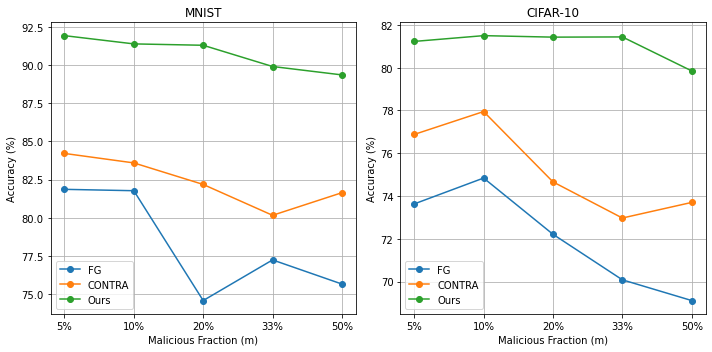

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data
m_values = ["5%", "10%", "20%", "33%", "50%"]

# MNIST data for alpha = 1
FG_MNIST = [81.86, 81.77, 74.58, 77.24, 75.66]
CONTRA_MNIST = [84.21, 83.59, 82.18, 80.16, 81.64]
Ours_MNIST = [91.92, 91.38, 91.29, 89.9, 89.35]

# CIFAR-10 data for alpha = 1
FG_CIFAR10 = [73.63, 74.84, 72.21, 70.08, 69.11]
CONTRA_CIFAR10 = [76.88, 77.95, 74.66, 72.97, 73.70]
Ours_CIFAR10 = [81.23, 81.5, 81.43, 81.44, 79.85]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot MNIST data
axs[0].plot(m_values, FG_MNIST, marker='o', label='FG')
axs[0].plot(m_values, CONTRA_MNIST, marker='o', label='CONTRA')
axs[0].plot(m_values, Ours_MNIST, marker='o', label='Ours')
axs[0].set_title('MNIST')
axs[0].set_xlabel('Malicious Fraction (m)')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend()
axs[0].grid(True)

# Plot CIFAR-10 data
axs[1].plot(m_values, FG_CIFAR10, marker='o', label='FG')
axs[1].plot(m_values, CONTRA_CIFAR10, marker='o', label='CONTRA')
axs[1].plot(m_values, Ours_CIFAR10, marker='o', label='Ours')
axs[1].set_title('CIFAR-10')
axs[1].set_xlabel('Malicious Fraction (m)')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Save the figure in IEEE conference standard format (usually a high-resolution format like PNG or PDF)
plt.savefig("results_plot.pdf", dpi=300)

# Show the plot
plt.show()
